In [2]:
from fipy import * 
import numpy as np
import matplotlib.pyplot as plt
from random import seed, randint

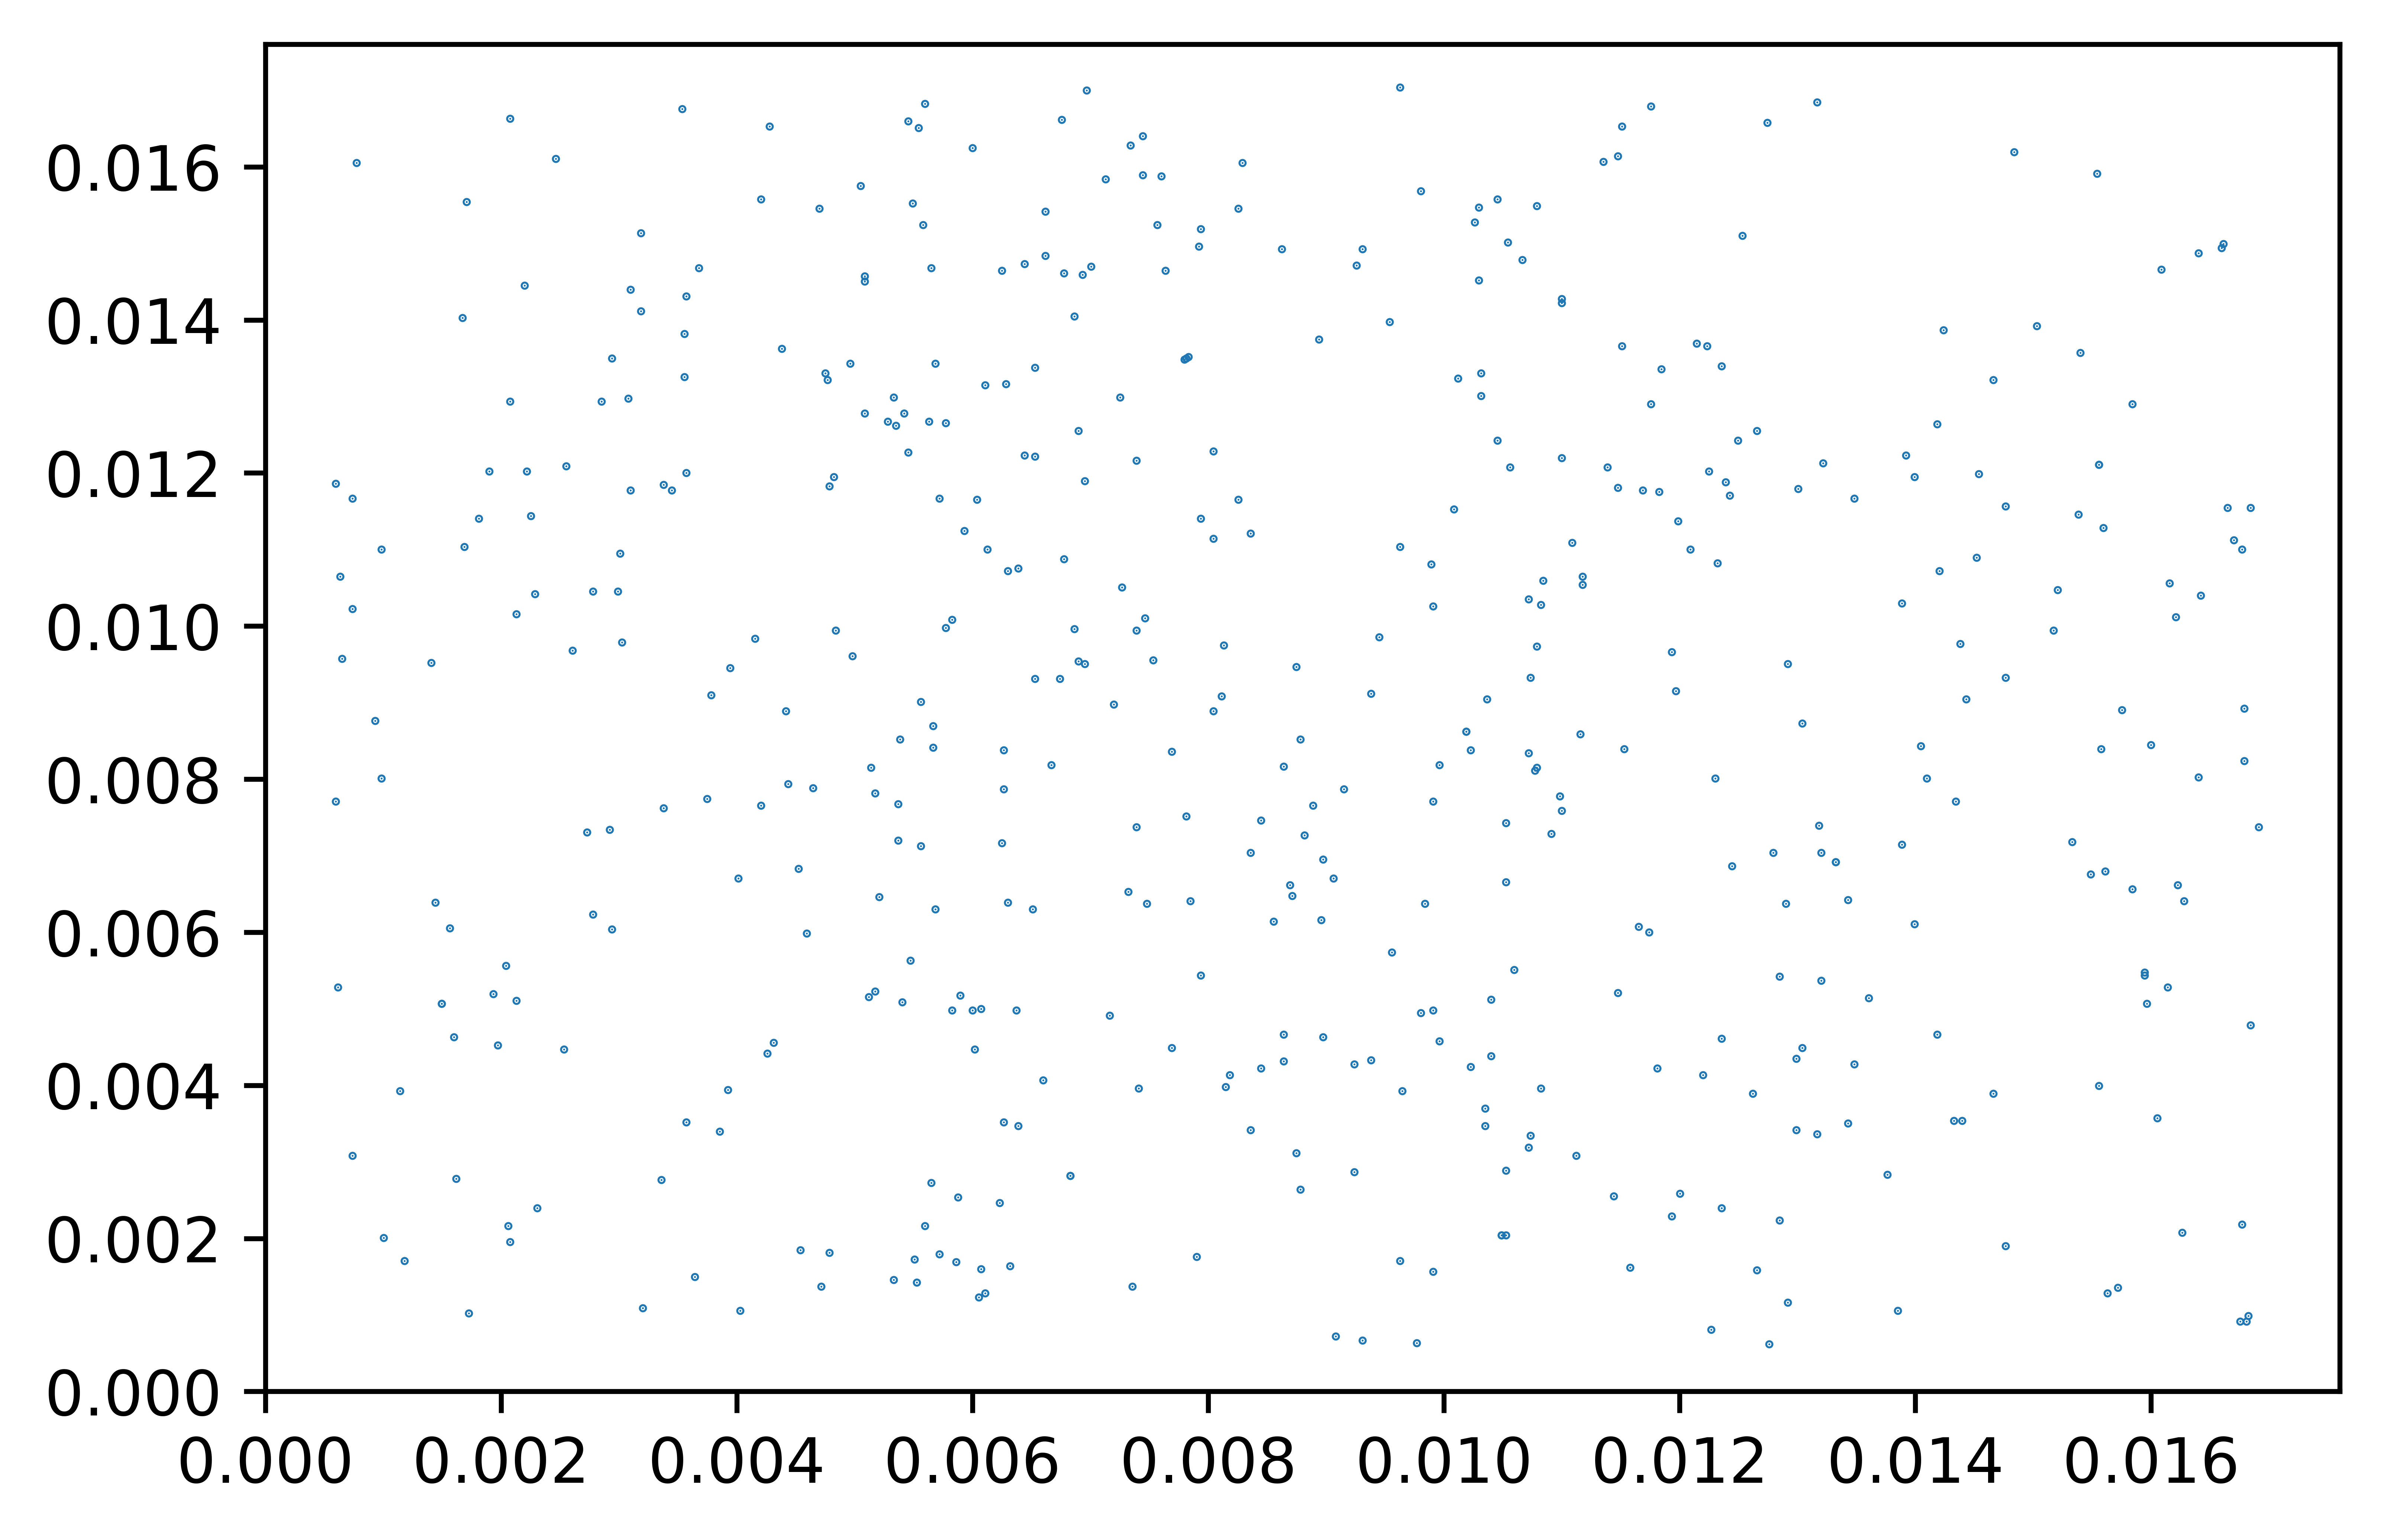

In [266]:
n=1000;
# generate random integer values
pos_x_inicial=randint(0, n)
pos_y_inicial=randint(0, n)

capsulas=100*100*0.22*0.22;
cap_pos_x=np.zeros(int(capsulas))
cap_pos_y=np.zeros(int(capsulas))

cap_pos_x[0]=pos_x_inicial
cap_pos_y[0]=pos_y_inicial

pos_x_actual=pos_x_inicial
pos_y_actual=pos_y_inicial
i=1
while i<capsulas:
    r=np.random.negative_binomial(n=1, p=0.0005);
    theta=2*np.random.random()*np.pi;
    x_nuevo=np.int(r*np.cos(theta))+pos_x_actual;
    y_nuevo=np.int(r*np.sin(theta))+pos_y_actual;
    if ((x_nuevo+r_cap<n) & (y_nuevo+r_cap<n) & (x_nuevo-r_cap>0) & (y_nuevo-r_cap>0)):
        cap_pos_x[i]=x_nuevo;
        cap_pos_y[i]=y_nuevo;
        
        pos_x_actual=x_nuevo;
        pos_y_actual=y_nuevo;
        i+=1
fig=plt.figure(dpi=1200)

cap_pos_x=0.0176*cap_pos_x/n;
cap_pos_y=0.0176*cap_pos_y/n;
plt.scatter(cap_pos_x,cap_pos_y,s=0.1)
plt.xlim([0,0.0176]);
plt.ylim([0,0.0176]);   

In [306]:
#Condiciones calculo camino libre medio
P=74660.32 #Pa
T=298 #K

#Constantes 
R=8.314 #J/mol K
Na=6.022e23 
#Propiedades oxigeno
d_m=346e-12 #m diametro kinetico O_2
c=0.21*P/(R*T) #mol/m3 concentracion de oxigeno en el aire

#Camino libre medio 
lamnda=1/(np.sqrt(2)*np.pi*d_m**2*c*Na) #m

#Diametro de poro
sigma=36.96e-10 #m Tomado de Tesis Reynel Gomez (2018)

#numero de Knudsen
K_n=lamnda/sigma

#Dimensiones Capsula
r_ext=6.09e-5#[m]
r_in=3.394e-5#[m]

#Vector de radio discretizado
grid_x,grid_y = np.meshgrid(np.linspace(0,0.0176,n),np.linspace(0,0.0176,n))

#Propiedades oxigeno
M=32e-3 #Kg/mol

#Propiedades Membrana 
vol_capsula=(4/3)*np.pi*(121e-7/2)**3 #cm3
peso_capsula=3.52E-16#g
vol_total=vol_capsula/peso_capsula
vol_poro=0.7183 #cm3/g

E=vol_poro/vol_total #Porosidad 
t_2=E**(1-1.5) #Tortuosidad 

#Calculo difusividad
def dif_knudsen(T=298):
    Ko=1/3 *d_m*E/t_2;
    v=np.sqrt(8*R*T/(np.pi*M))
    D_k=Ko*v
    return D_k

#Difusividad y solubilidad de oxigeno en aceite
def Difusividad(T=298):
    R=8.314
    Dac=0.4e-9 #m2/s
    D_k=dif_knudsen(T) #m2/s
    D_pol=0.43e-4*np.exp(-36581.6/(R*T))
    return D_k,Dac,D_pol

def Solubilidad(T=298):
    R=8.314;
    Sac=6.858e6*np.exp(-1.478e4/(R*T)); #Pa m3/mol
    S_sol=2.0962E-5*np.exp(-1700/(R*T))
    return 1/(R*T),1/Sac,S_sol

def cons_cinetica(T=298):
    R=8.314;
    return np.asarray([52691244*np.exp(-101.5e3/(R*T)),6581,572.68*np.exp(-31e3/(R*T)),2.2914e+08,10362358.9,96814085.92*np.exp(-48.4e3/(R*T))])

In [330]:
D_si,D_ac,D_pol=Difusividad()
S_si,S_ac,S_pol=Solubilidad()

ROOH_o=19.1789709;
RH_o=1559.37052;

i=0;
D=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*D_ac+((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_ext**2)*D_si
D=D-((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*D_si
S=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*S_ac+((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_ext**2)*S_si
S=S-((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*S_si
ROOH_inicial=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*ROOH_o
RH_inicial=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*RH_o

for i in range(1,len(cap_pos_x)):
        val=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*(D_ac-D_si)+((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_ext**2)*D_si
        D=D+val*(D==0)
        val_s=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*(S_ac-S_si)+((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_ext**2)*S_si
        S=S+val_s*(S==0)
        val_ROOH=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*ROOH_o
        ROOH_inicial=ROOH_inicial+val_ROOH
        val_RH=((grid_x-cap_pos_x[i])**2+(grid_y-cap_pos_y[i])**2<r_in**2)*RH_o
        RH_inicial=RH_inicial+val_RH
D=D+(D==0)*D_pol
S=S+(S==0)*S_pol

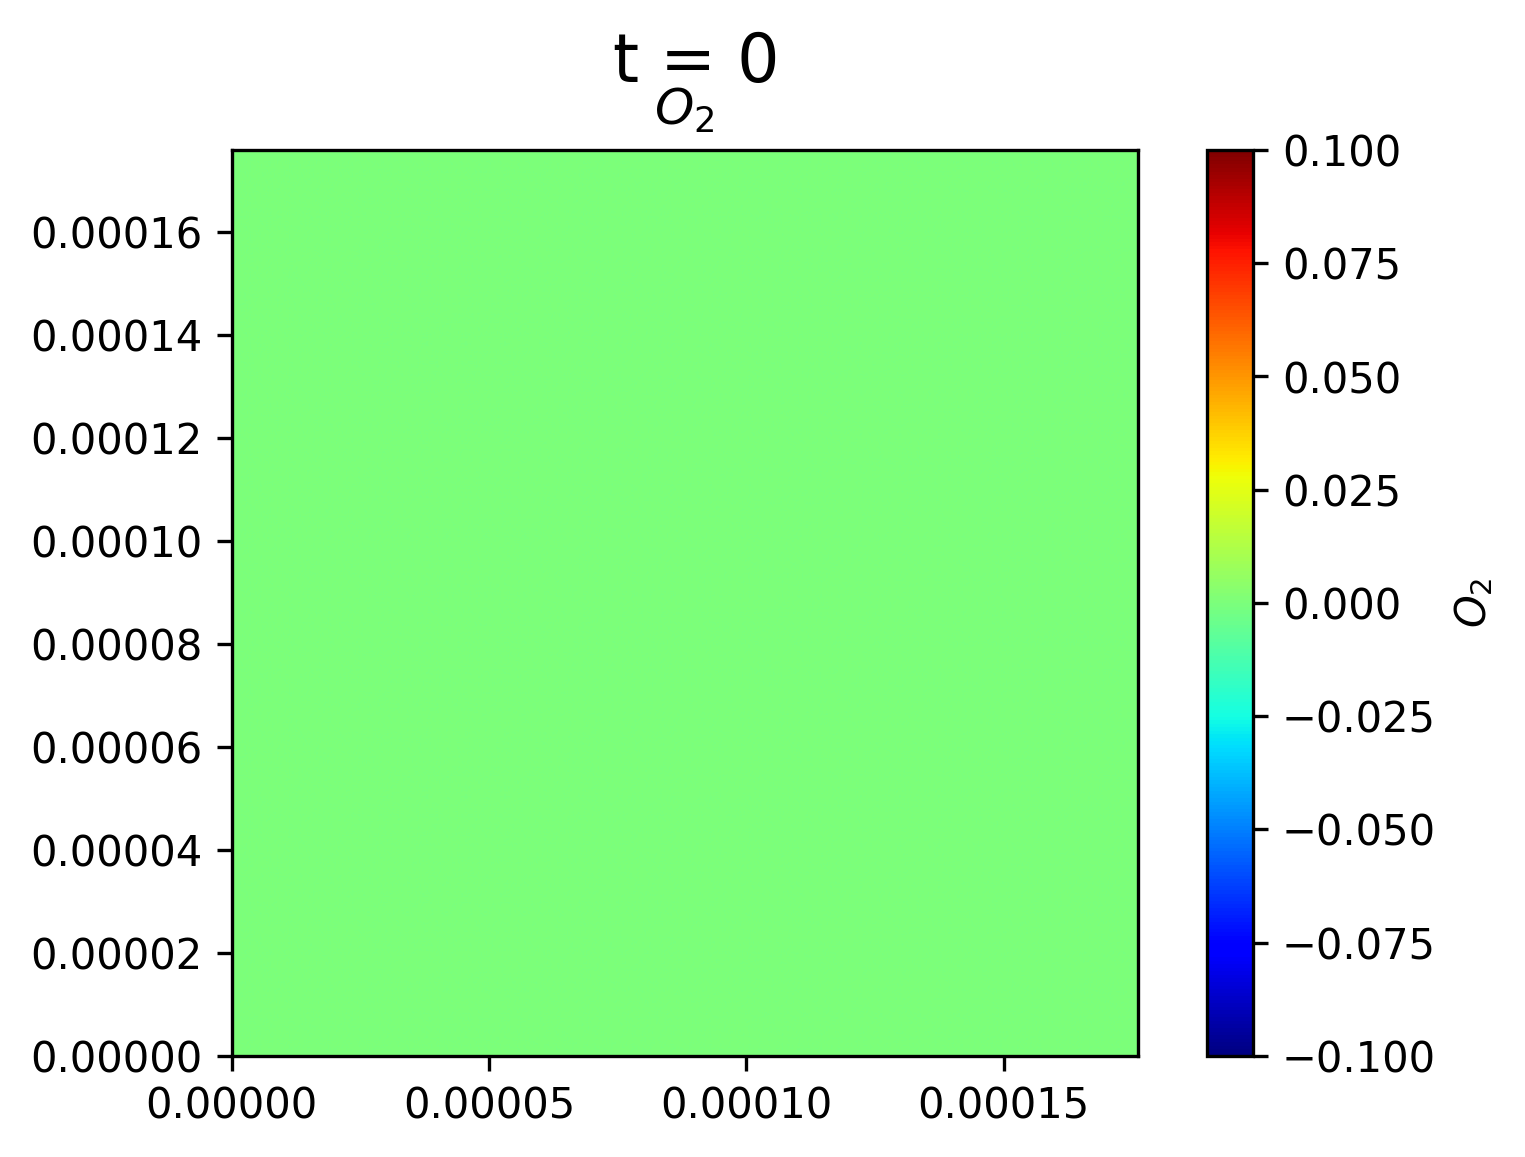

In [337]:
k=cons_cinetica()
dx=0.0176*1e-2/n
#dx=np.linspace(0,0.0176*1e-2,n)[1]
mesh = Grid2D(nx=n, ny=n, dx=dx, dy=dx)


O2 = CellVariable(name=r"$O_2$", mesh=mesh,hasOld=True)
O2.constrain(0.21*P, where=mesh.facesLeft)
ROOH = CellVariable(name=r"$ROOH$", mesh=mesh,hasOld=True)
RH = CellVariable(name=r"$RH$", mesh=mesh,hasOld=True)
ROO = CellVariable(name=r"$ROO\cdot$", mesh=mesh,hasOld=True)
R_reac = CellVariable(name=r"$R\cdot$", mesh=mesh,hasOld=True)


#O2.value=np.reshape(O2_inicial,n*n);
ROOH.value=np.reshape(ROOH_inicial,n*n);
RH.value=np.reshape(RH_inicial,n*n);


D1=CellVariable(mesh=mesh, value=np.reshape(D,n*n))
S1=CellVariable(mesh=mesh, value=np.reshape(S,n*n))

elapsed = 0
fig=plt.figure(dpi=300)
fig.suptitle('t = %.2g' %(elapsed), fontsize=16)
#viewer_def=MultiViewer(viewers=(MatplotlibViewer(vars=O2,datamin=0,datamax=O2o,axes=fig.add_subplot(121)),(MatplotlibViewer(vars=O2*S1,axes=fig.add_subplot(122),datamin=0,datamax=O2o*S_si,))) )
viewer_def =MultiViewer(viewers=(MatplotlibViewer(vars=O2,datamin=0,datamax=0.21*P,axes=fig.add_subplot(111))))

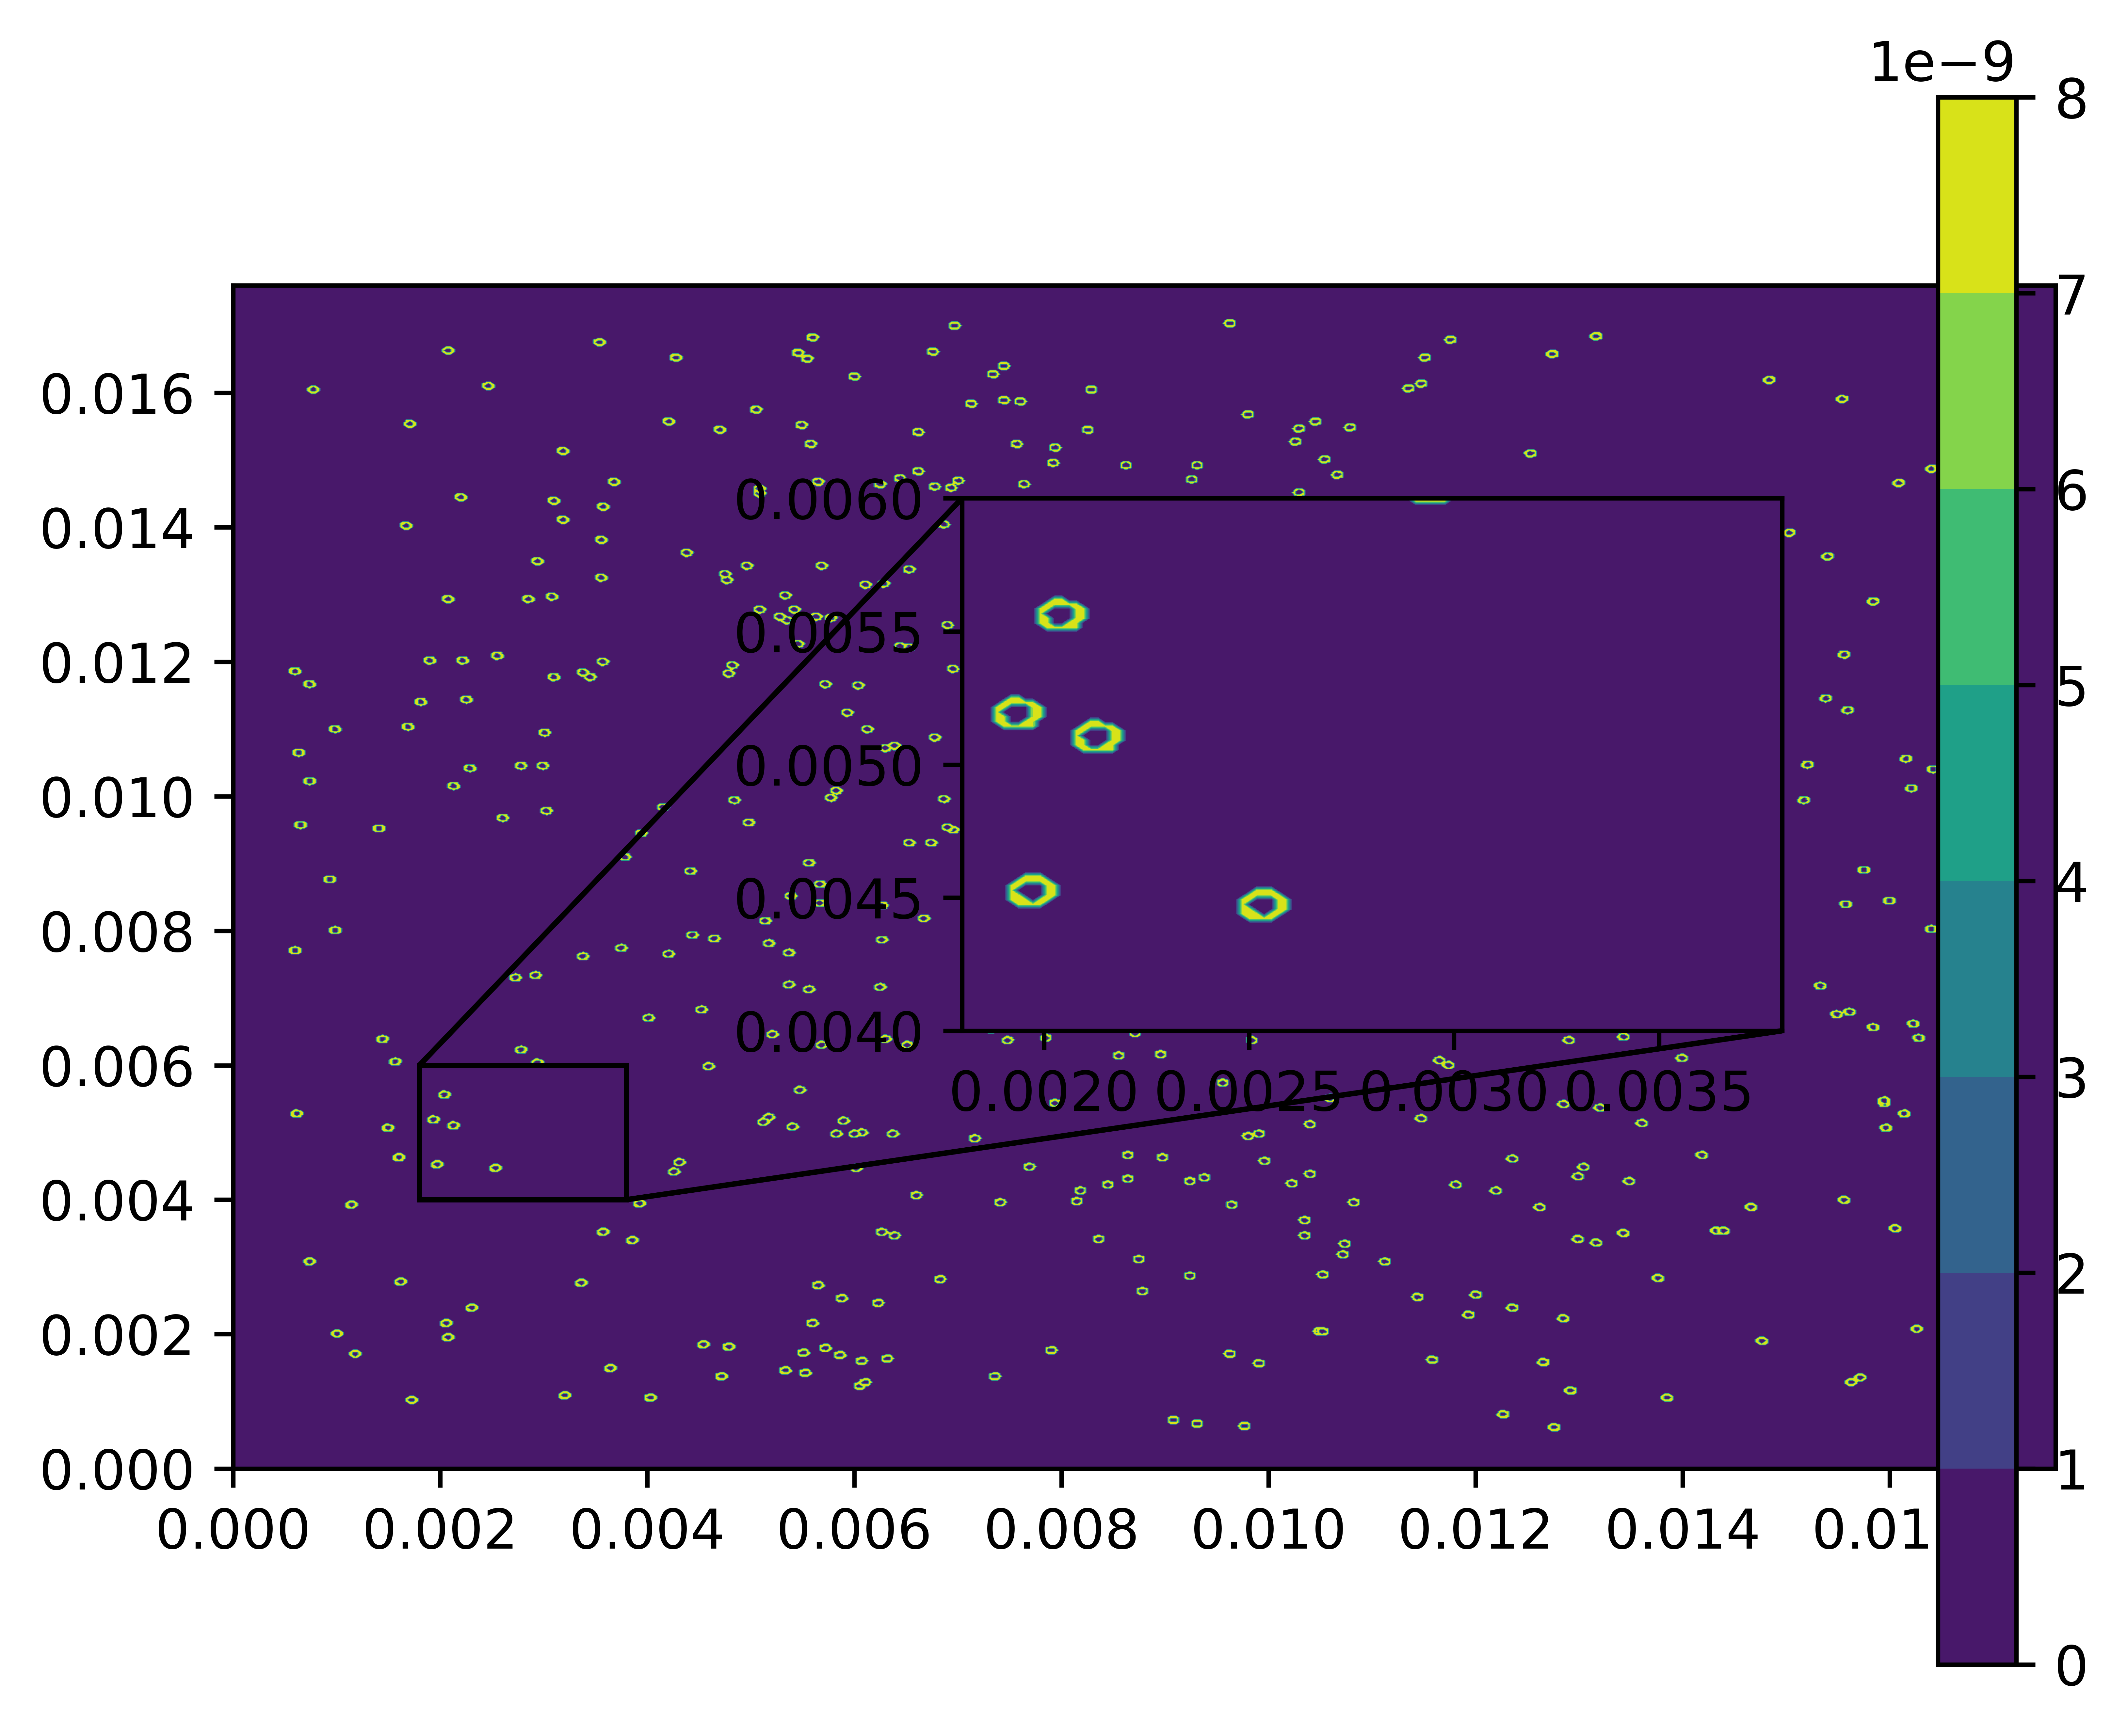

In [336]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

fig, ax = plt.subplots(dpi=1200)
a=ax.contourf(grid_x,grid_y,D)
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.4,0.37,0.45,0.45])
#ax2.set_title(r'Regímen Difusivo')
ax2.set_axes_locator(ip)
ax2.contourf(grid_x,grid_y,D)
ax2.set_xlim([0.0018,0.0038])
ax2.set_ylim([00.004,0.006])
#ax2.ticklabel_format(axis='y',useOffset=False)
mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='k');
plt.colorbar(a)

In [292]:
np.unique(ROOH_inicial)

array([ 0.       , 19.1789709])

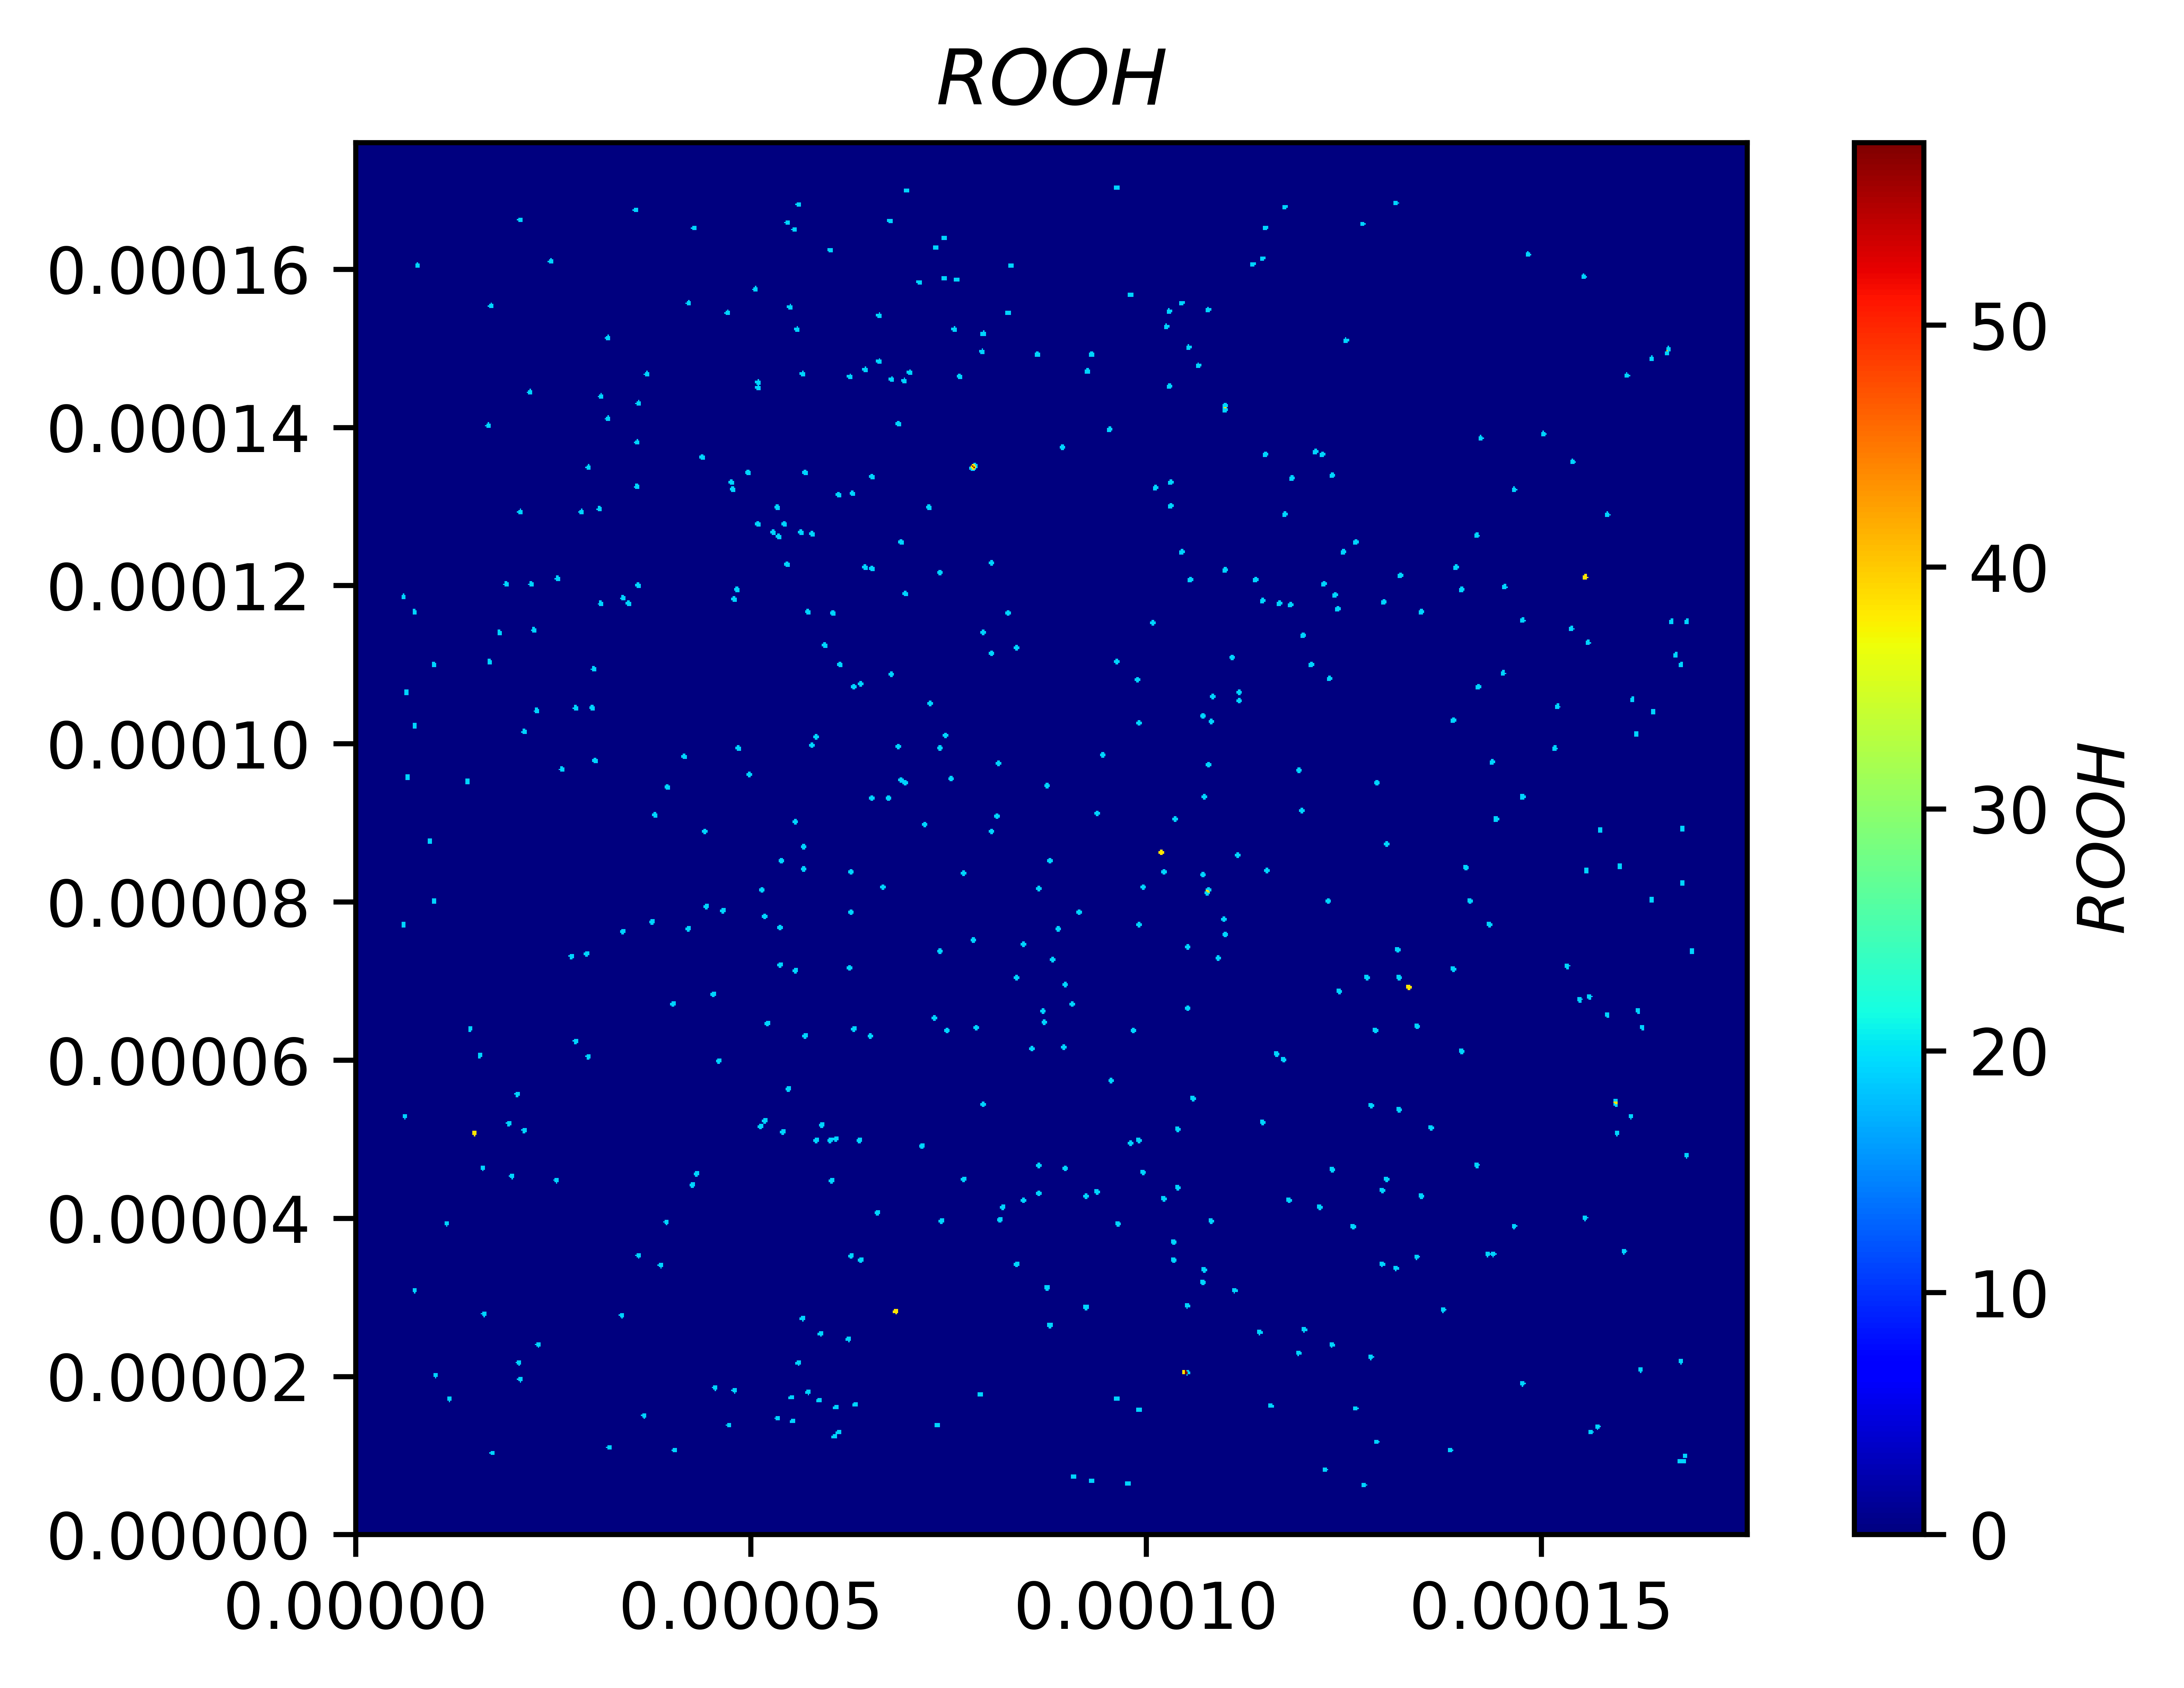

In [338]:
fig_2=plt.figure(dpi=1200)
viewer_def_2 =MultiViewer(viewers=(MatplotlibViewer(vars=ROOH,datamin=0,axes=fig_2.add_subplot(111))))

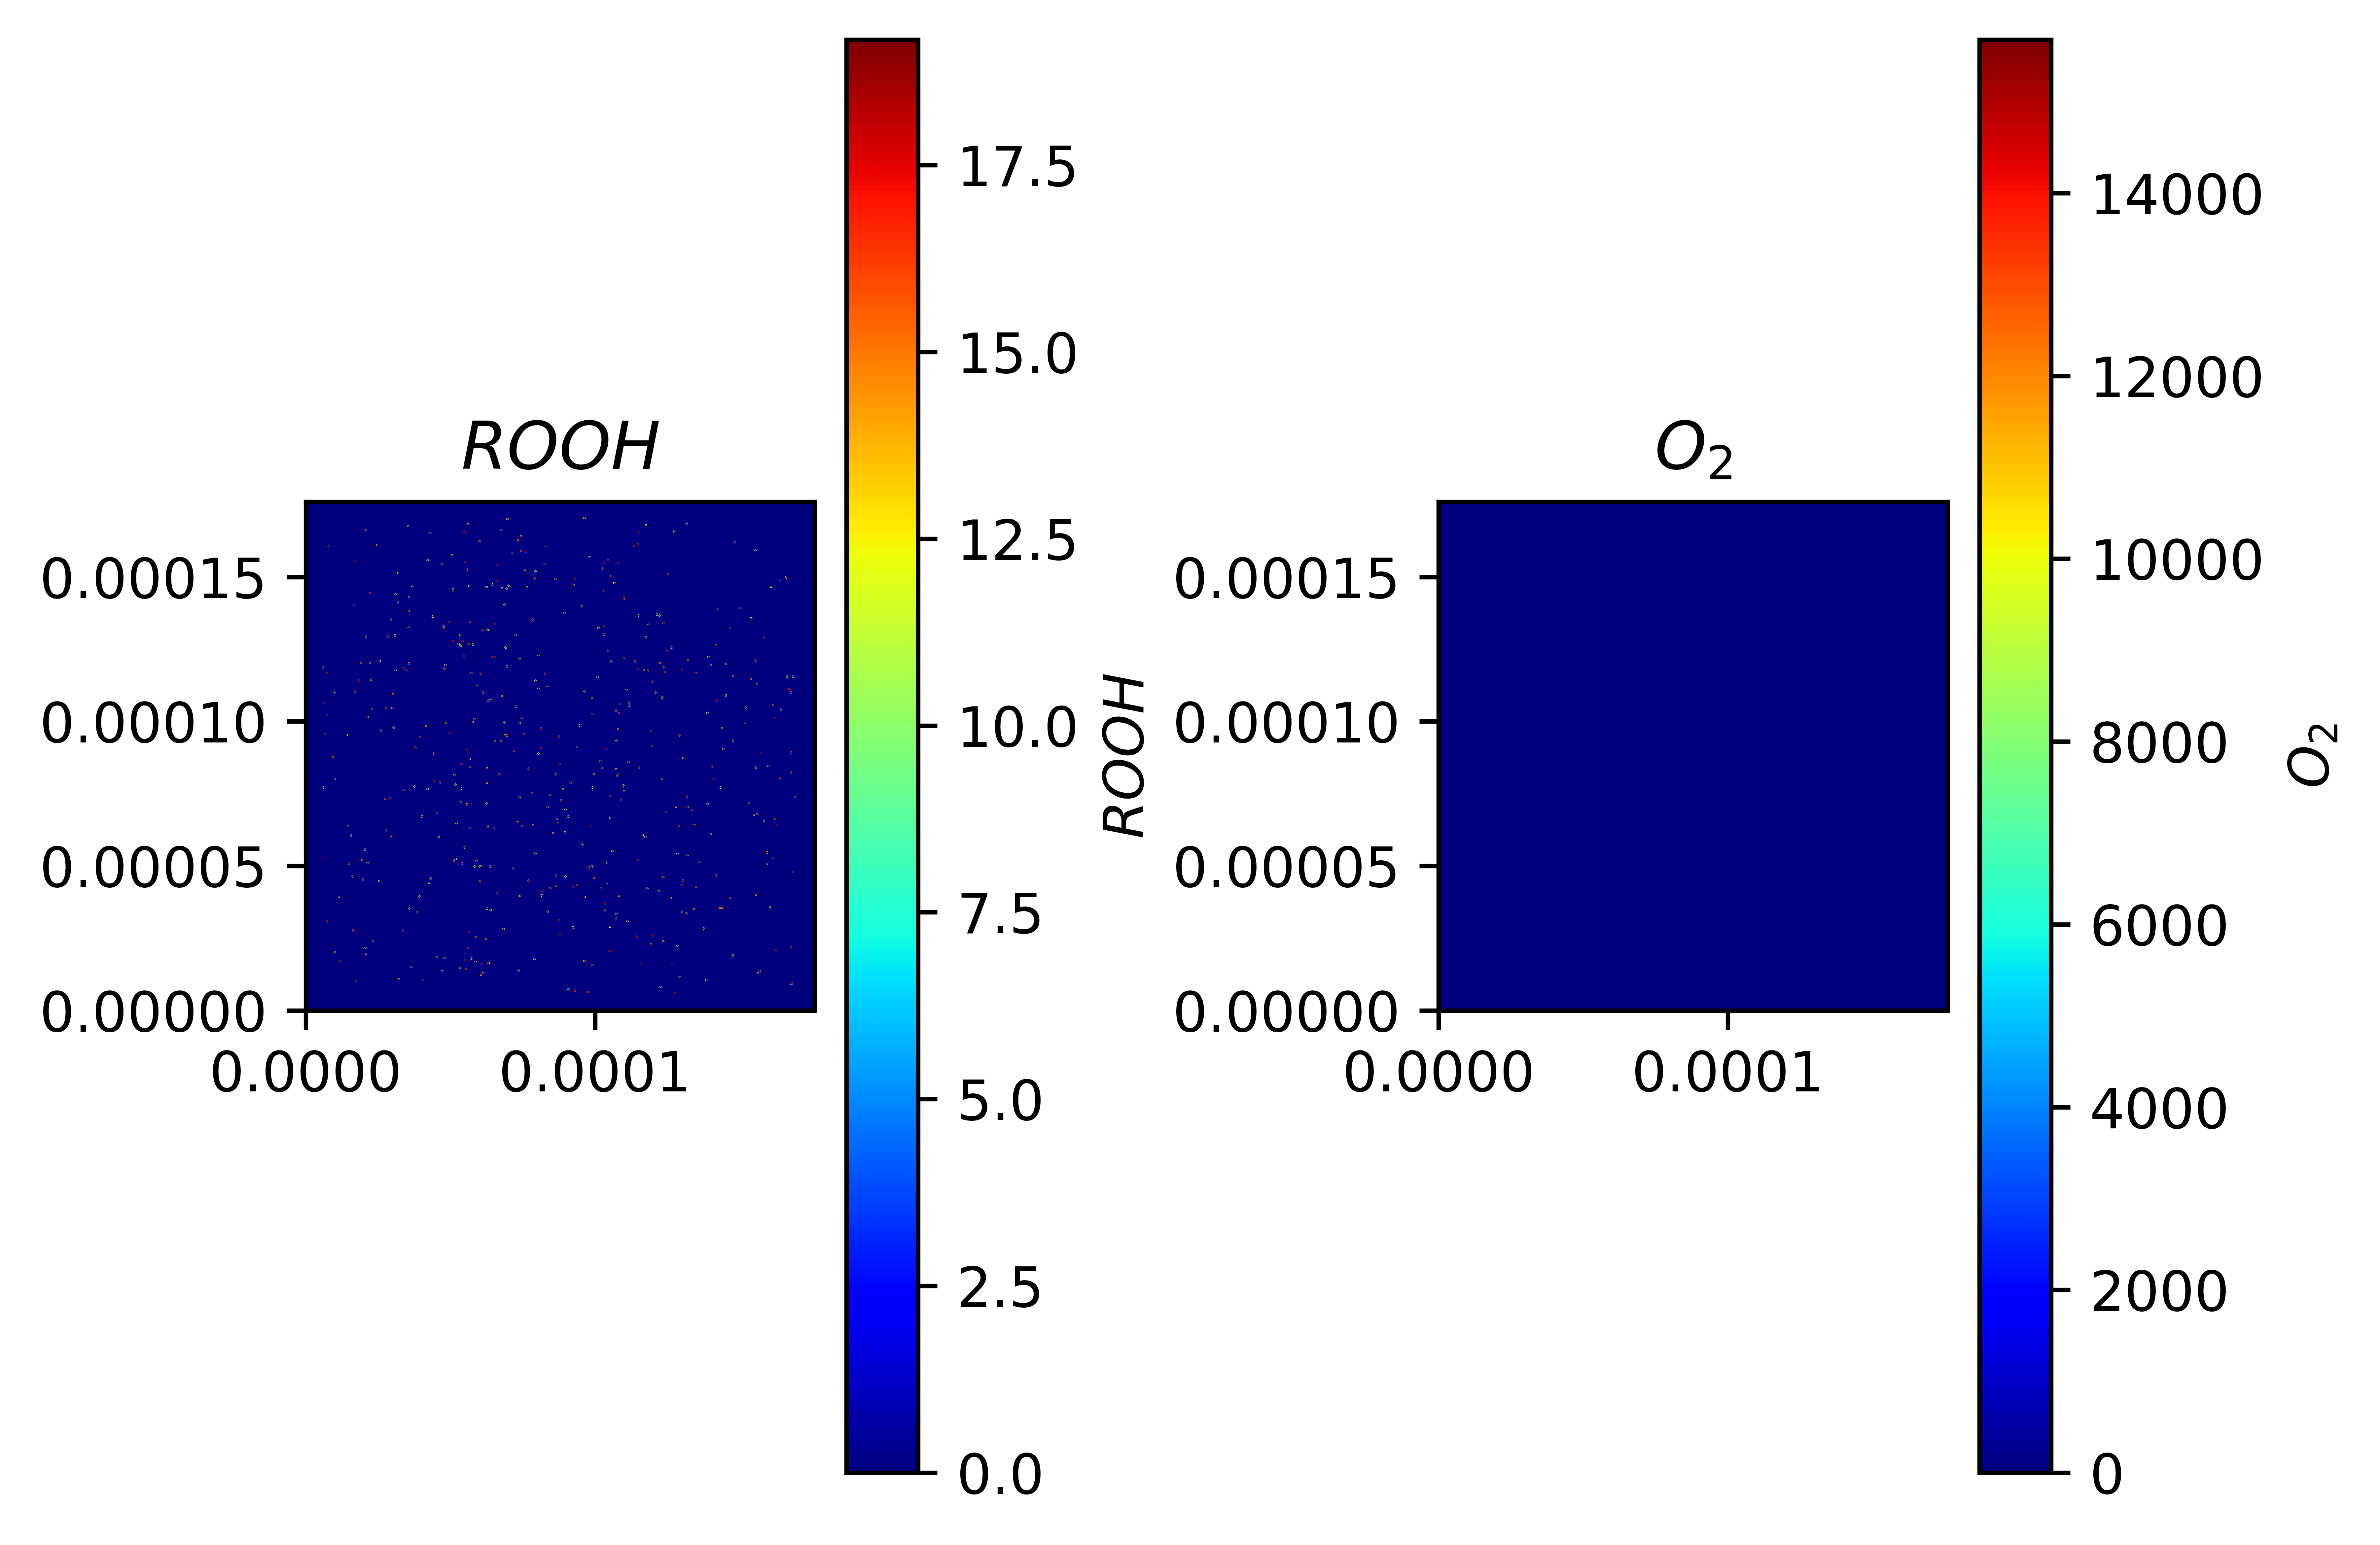

In [340]:
fig_2=plt.figure(dpi=1200)
viewer_def_2 =MultiViewer(viewers=(MatplotlibViewer(vars=ROOH,datamin=0,datamax=ROOH_o,axes=fig_2.add_subplot(121)),MatplotlibViewer(vars=O2,datamin=0,datamax=0.21*P,axes=fig_2.add_subplot(122))))
fig_2.tight_layout()

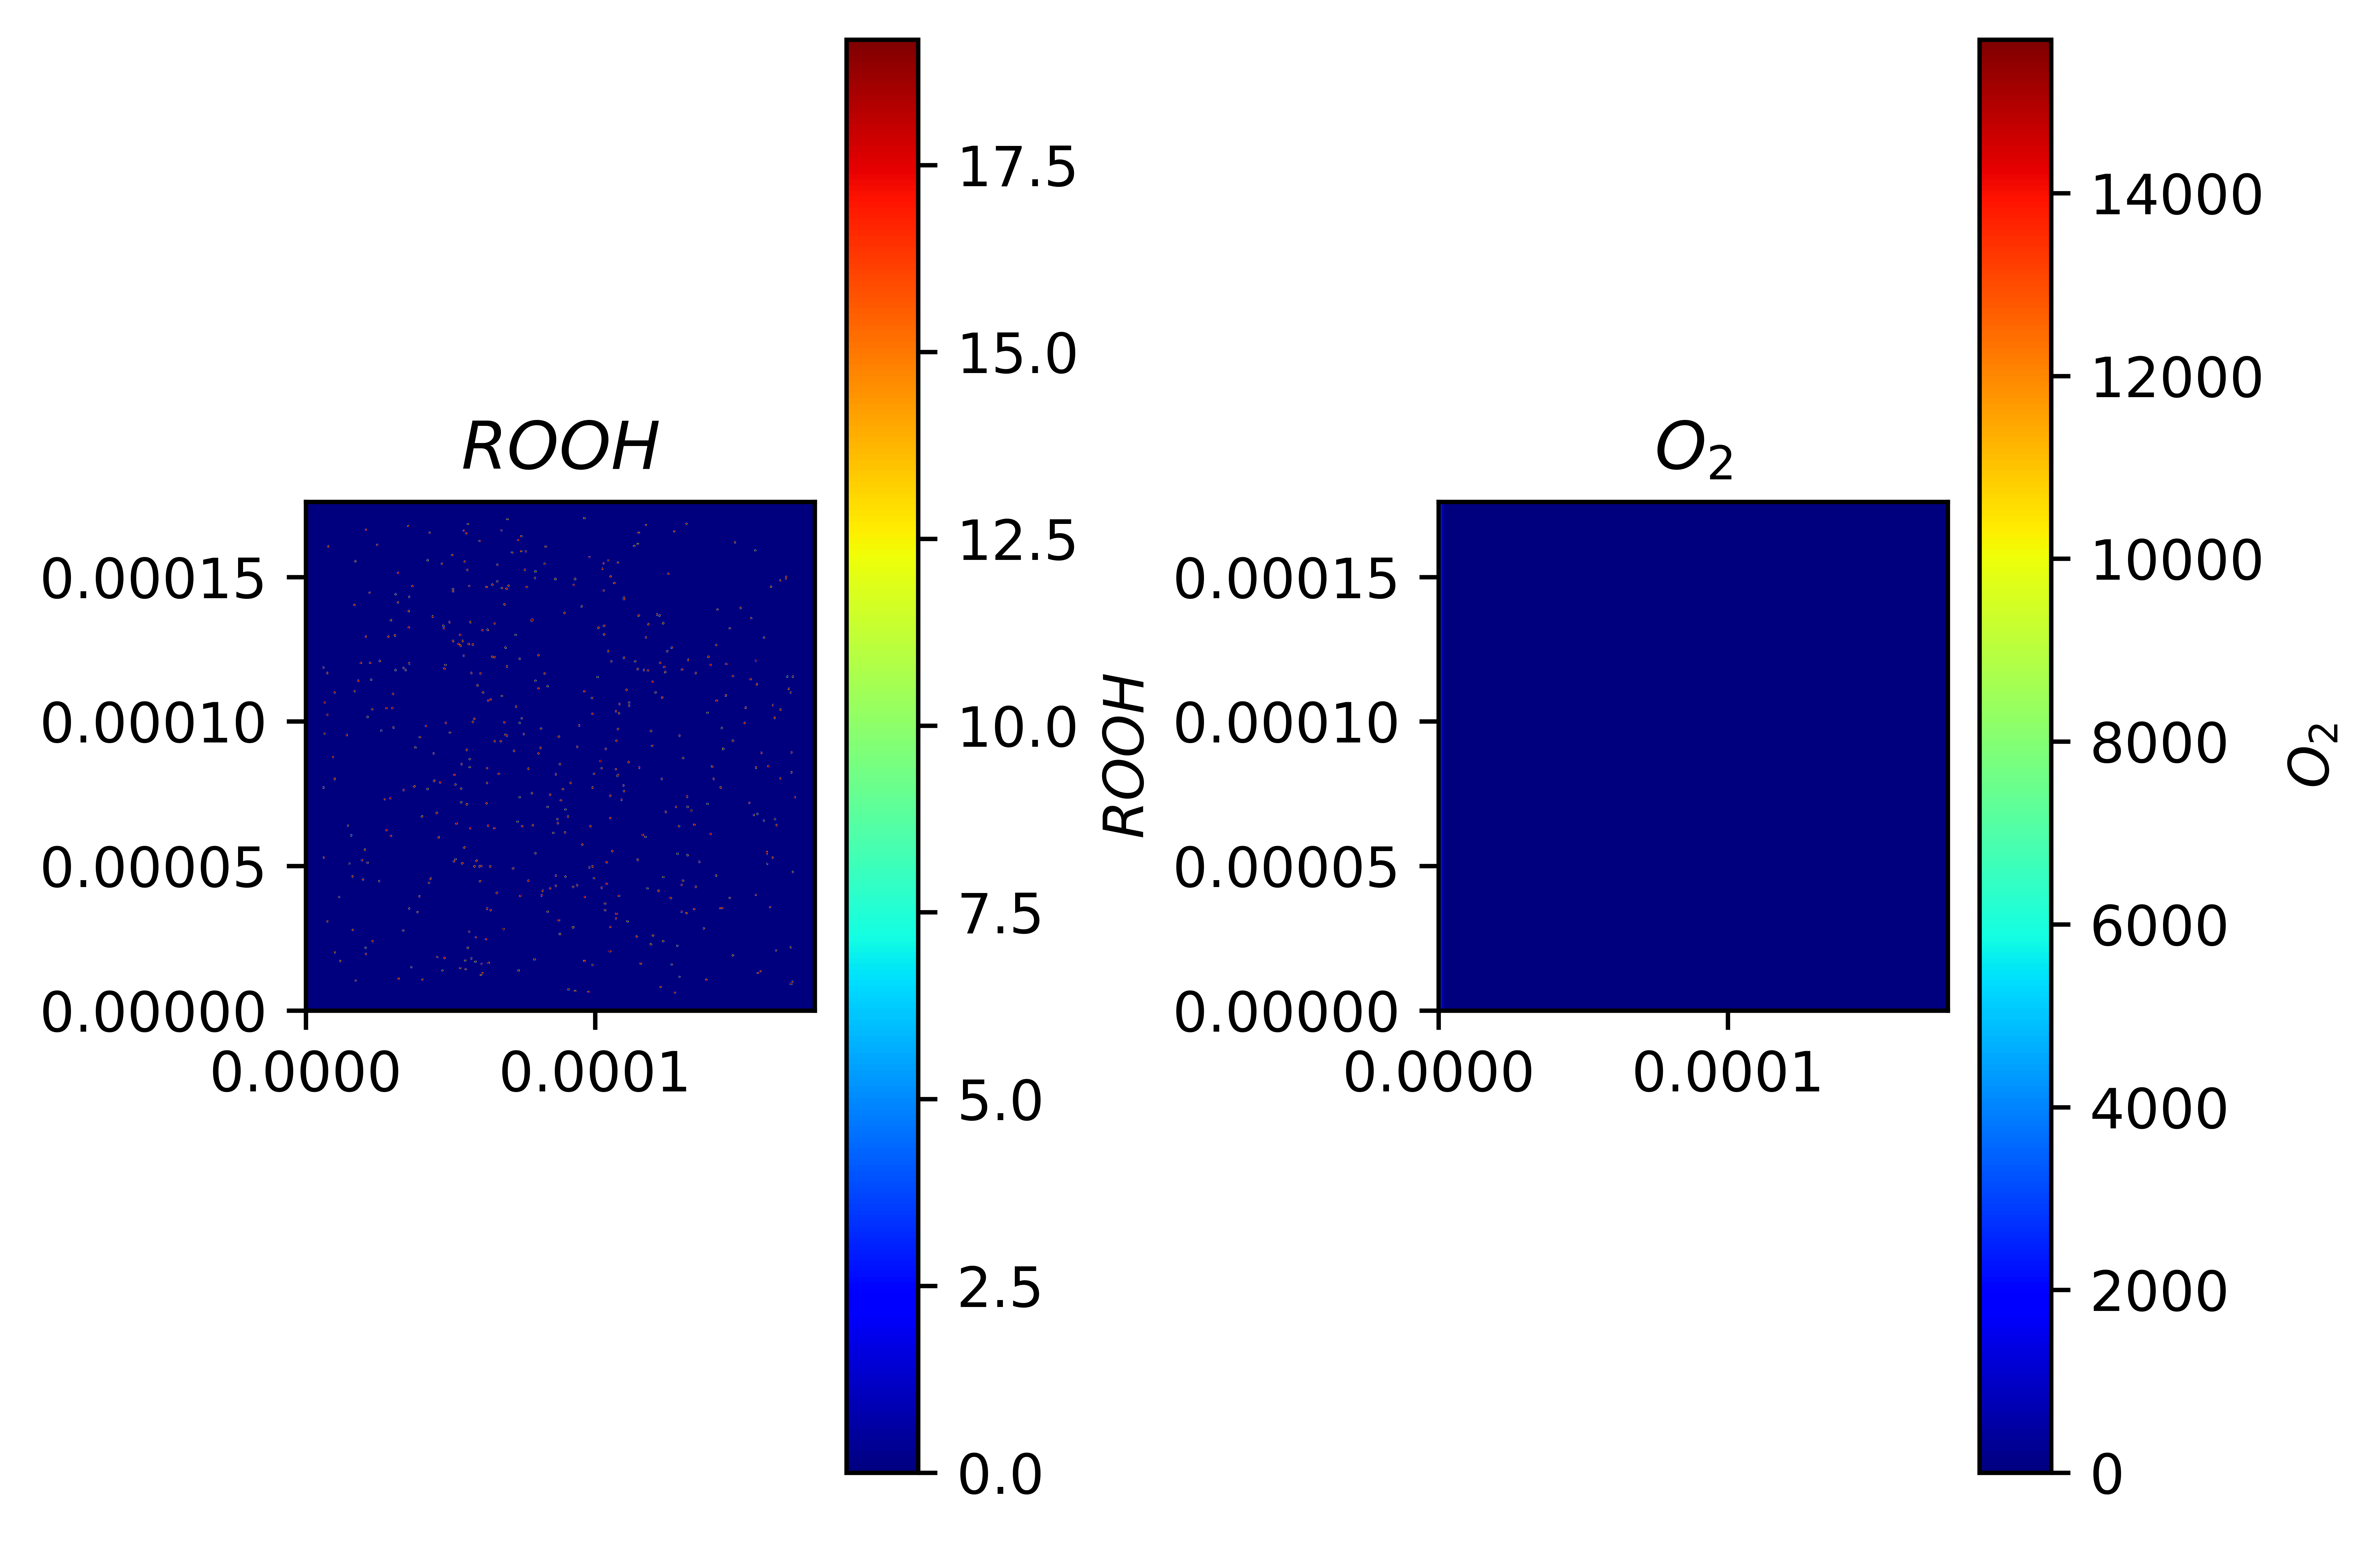

SystemError: gstrf was called with invalid arguments

<Figure size 432x288 with 0 Axes>

In [341]:
reacc_1=k[0]*ROOH
reacc_2=k[1]*O2*S1
reacc_2_alt=k[1]*R_reac
reacc_3=k[2]*RH
reacc_4=k[3]*R_reac
reacc_5=k[4]*R_reac
reacc_6=k[5]*ROO


eqn0= (TransientTerm(var=O2) == DiffusionTerm(coeff=D1,var=O2)-ImplicitSourceTerm(coeff=reacc_2_alt,var=O2))
eqn1= (TransientTerm(var=ROOH) == -2*ImplicitSourceTerm(coeff=reacc_1,var=ROOH)+ImplicitSourceTerm(coeff=reacc_3,var=ROO))
eqn2= (TransientTerm(var=ROO) == ImplicitSourceTerm(coeff=reacc_1,var=ROOH)+ImplicitSourceTerm(coeff=reacc_2, var=R_reac)-ImplicitSourceTerm(coeff=reacc_3,var=ROO)-ImplicitSourceTerm(coeff=reacc_5, var=ROO)-2*ImplicitSourceTerm(coeff=reacc_6, var=ROO))
eqn3= (TransientTerm(var=R_reac) == ImplicitSourceTerm(coeff=reacc_1,var=ROOH)-ImplicitSourceTerm(coeff=reacc_2, var=R_reac)+ImplicitSourceTerm(coeff=reacc_3,var=ROO)-2*ImplicitSourceTerm(coeff=reacc_4, var=R_reac)-ImplicitSourceTerm(coeff=reacc_5, var=ROO))
eqn4= (TransientTerm(var=RH) == -ImplicitSourceTerm(coeff=reacc_3,var=ROO))

eq = eqn0 & eqn1 & eqn2 &  eqn3 &  eqn4
dexp = -5
elapsed = 0


while elapsed < 3600*4:
    dt = min(100, np.exp(dexp))
    elapsed += dt
    dexp += 0.01
   
    elapsed += dt
    
    O2.updateOld()
    ROOH.updateOld()
    ROO.updateOld()
    R_reac.updateOld()
    RH.updateOld()
    
    eq.solve(dt=dt)
    viewer_def_2.plot()
    fig.suptitle('t = %.2g' %(elapsed), fontsize=16)